In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.style as style 
# magic word for producing visualizations in notebook
%matplotlib inline
import warnings
# utility functions
import utility 


In [2]:
# option to filter certain warning info
warnings.filterwarnings('ignore')
# option to set max display rows
pd.options.display.max_rows = 999

In [3]:
#read clanedar and listings data
calendar_data = pd.read_csv('./input/calendar.csv', header = 0)
listings_data = pd.read_csv('./input/listings.csv', header = 0)

In [4]:
#check calendar data
calendar_data.info()
calendar_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420680 entries, 0 to 2420679
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         object
dtypes: int64(1), object(3)
memory usage: 73.9+ MB


,listing_id,date,available,price
0,958,2019-08-05,f,NaN
1,958,2019-08-04,f,NaN
2,958,2019-08-03,f,NaN
3,958,2019-08-02,f,NaN
4,958,2019-08-01,f,NaN


# Explore calendar data set

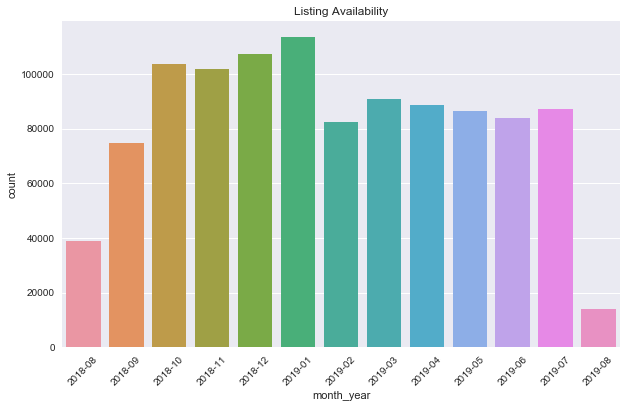

In [5]:
#find list availability in next 12 months
calendar_data_t = calendar_data[calendar_data['available']=='t']
calendar_data_t['date'] = pd.to_datetime(calendar_data_t['date'])
calendar_data_t['month_year'] = calendar_data_t['date'].apply(lambda x:x.strftime('%Y-%m'))
calendar_data_t.sort_values(by='month_year',inplace=True)
g = sns.countplot(x='month_year', data=calendar_data_t)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
g.legend(loc=1)
g.figure.set_size_inches(10,6)
g.set_title("Listing Availability")

Percentage of listings with price <$500: 94.2%


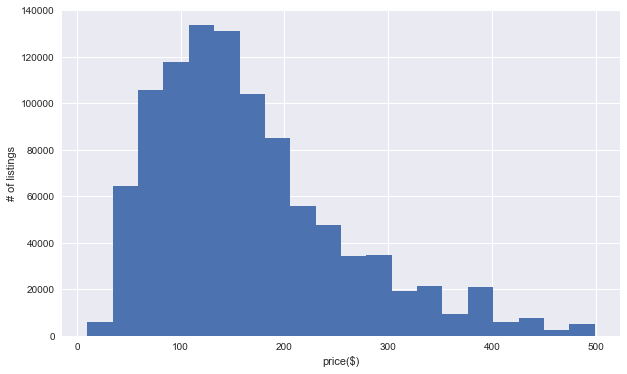

In [6]:
#find price distribution in next 12 months
calendar_data_t[['price']] =calendar_data_t[['price']].replace('[\$,]', '', regex=True).astype(float)
#set price cut-off to exclude outliers (i.e., listigns with extremenely high price)
pirce_limit= 500
calendar_data_t_low = calendar_data_t[calendar_data_t['price']<pirce_limit]
print("Percentage of listings with price <${}: {}%".format\
      (pirce_limit,round(calendar_data_t_low.shape[0]/calendar_data_t.shape[0]*100,1)))
ax=calendar_data_t_low.price.hist(bins=20)
ax.set_xlabel("price($)")
ax.set_ylabel("# of listings")
ax.figure.set_size_inches(10,6)

Percentage of listings with price >=$500: 5.8%


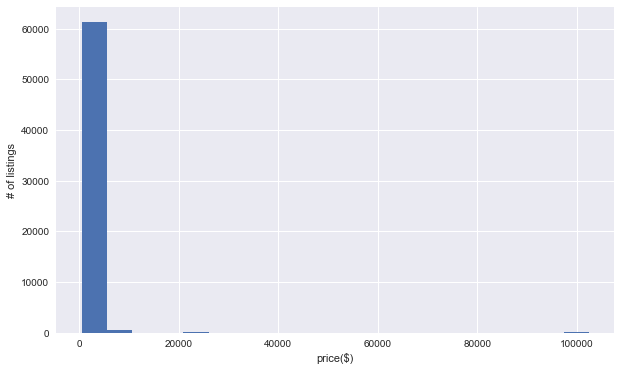

In [7]:
calendar_data_t_high = calendar_data_t[calendar_data_t['price']>=pirce_limit]
print("Percentage of listings with price >=${}: {}%".format\
      (pirce_limit,round(calendar_data_t_high.shape[0]/calendar_data_t.shape[0]*100,1)))
ax=calendar_data_t_high.price.hist(bins=20)
ax.set_xlabel("price($)")
ax.set_ylabel("# of listings")
ax.figure.set_size_inches(10,6)

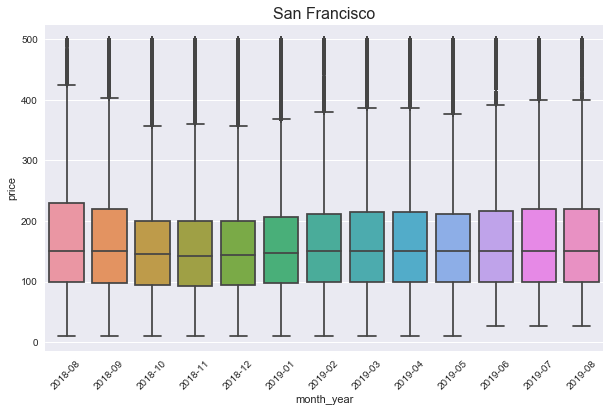

In [8]:
#boxplot of price after exluding outliers
style.use('seaborn-colorblind')
sns.set_style("darkgrid")
g=sns.boxplot(data=calendar_data_t_low, x='month_year',y='price')
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
g.set_title("San Francisco", fontsize=16)
g.figure.set_size_inches(10,6)

In [9]:
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'seaborn-paper',
 'bmh',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

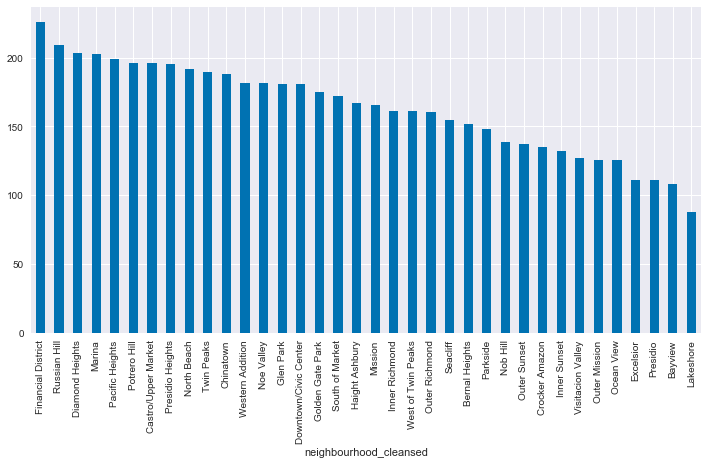

In [10]:
#check price distribution over neighbourhoods
list_neighbourhood =listings_data[['id','neighbourhood_cleansed']]
calendar_neighbourhood_data = pd.merge(calendar_data_t_low, list_neighbourhood, left_on='listing_id', right_on='id')
df_neighbourhood = calendar_neighbourhood_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
df_neighbourhood.plot(x=df_neighbourhood.index,y=df_neighbourhood.values, kind="bar", figsize=(12,6))

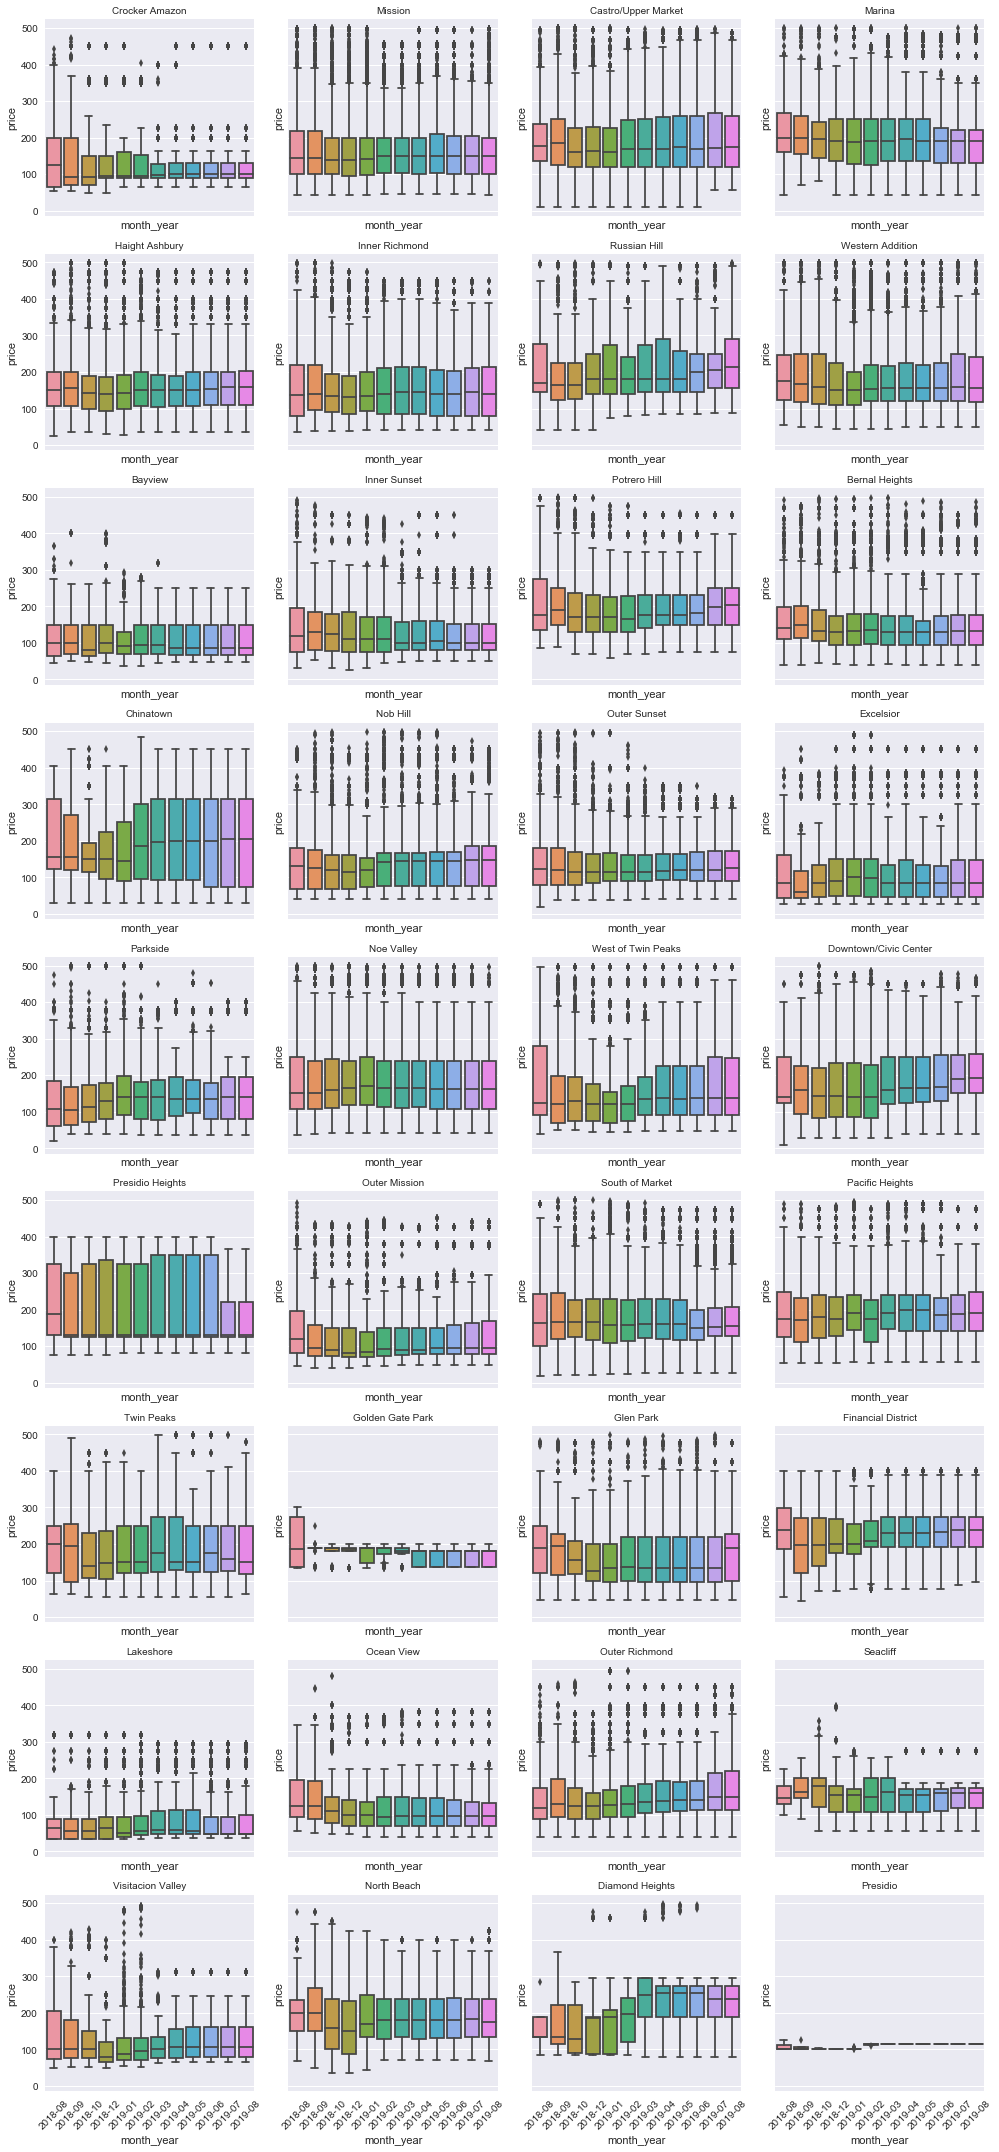

In [11]:
#check price distribution over neighbourhoods over next 12 months
neighbours = calendar_neighbourhood_data['neighbourhood_cleansed'].unique()
#boxplot of price after exluding outliers
style.use('seaborn-colorblind')
sns.set_style("darkgrid")
fig, axes = plt.subplots(9, 4,sharex=True, sharey=True)
fig.set_size_inches(14, 30)

for i, ax in enumerate(axes.flatten()):
        neighbours_subset = calendar_neighbourhood_data[calendar_neighbourhood_data['neighbourhood_cleansed']==neighbours[i]]
        g=sns.boxplot(ax=ax,data=neighbours_subset, x='month_year',y='price')
        ax.set_title(neighbours[i], fontsize=10)
        loc, labels = plt.xticks()
        g.set_xticklabels(labels, rotation=45)
       
plt.tight_layout()

# Explore and clean listings data set

In [12]:
#check listings data
listings_data.info()
listings_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6633 entries, 0 to 6632
Data columns (total 96 columns):
id                                  6633 non-null int64
listing_url                         6633 non-null object
scrape_id                           6633 non-null int64
last_scraped                        6633 non-null object
name                                6633 non-null object
summary                             6405 non-null object
space                               5592 non-null object
description                         6609 non-null object
experiences_offered                 6633 non-null object
neighborhood_overview               4716 non-null object
notes                               4046 non-null object
transit                             4782 non-null object
access                              4576 non-null object
interaction                         4452 non-null object
house_rules                         4855 non-null object
thumbnail_url                       0 no

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20180806171132,2018-08-06,"Bright, Modern Garden Unit - 1BR/1B",Our bright garden unit overlooks a grassy back...,"Newly remodeled, modern, and bright garden uni...",Our bright garden unit overlooks a grassy back...,none,*Quiet cul de sac in friendly neighborhood *St...,...,t,STR-0001256,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1.38
1,5858,https://www.airbnb.com/rooms/5858,20180806171132,2018-08-06,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,1,0.99
2,7918,https://www.airbnb.com/rooms/7918,20180806171132,2018-08-06,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,9,0.16
3,8142,https://www.airbnb.com/rooms/8142,20180806171132,2018-08-06,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,none,NaN,...,t,NaN,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,9,0.15
4,8339,https://www.airbnb.com/rooms/8339,20180806171132,2018-08-06,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,none,NaN,...,t,STR-0000264,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,t,t,2,0.24


## Select initial relevant features and recode categorical features

In [13]:
#Keep initial list of listing features relevant to review rating and occupancy (reviews_per_month)
#DESCRIPTIONS - name, summary, space, description
#HOST - host_since, host_response_time, host_response_rate, host_is_superhost,host_listings_count,
#       calculated_host_listings_count
#HOME DETAILS - property_type, room_type, accomodates, bathrooms, bedrooms, beds, bed_type, amenities
#               availability_30,availability_60,availability_90,availability_365, neighbourhood_cleansed
#LISTING ELEMENTS - price, cleaning_fee, extra_people, minimum_nights, maximum_nights, 
#                   instant_bookable, cancellation policy
#Review VARIABLES - 'review_scores_rating', 'review_scores_accuracy', review_scores_cleanliness', 
#                    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
#                    'review_scores_value',reviews_per_month


ld = listings_data.loc[:,['name', 'summary', 'space', 'description',\
    'host_since','host_response_time', 'host_response_rate', 'host_is_superhost',\
    'calculated_host_listings_count','host_has_profile_pic','host_identity_verified',\
    'neighbourhood_cleansed','property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',\
    'amenities', 'price', 'cleaning_fee', 'security_deposit','extra_people','minimum_nights',\
    'maximum_nights', 'instant_bookable','cancellation_policy',\
    'has_availability','availability_30','availability_60','availability_90','availability_365',\
    'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',\
    'review_scores_checkin', 'review_scores_communication','review_scores_location', 'review_scores_value',\
    'number_of_reviews','reviews_per_month']]

In [14]:
#Get lengths of description elements in order to measure description details of listings
ld.loc[:,'name_length'] = ld['name'].str.len()
ld.loc[:,'summary_length'] = ld['summary'].str.len()
ld.loc[:,'space_length'] = ld['space'].str.len()
ld.loc[:,'description_length'] = ld['description'].str.len()
ld.loc[:,'amenities_length'] = ld['amenities'].str.len()
ld.loc[:,'name_length'].fillna(0, inplace=True)
ld.loc[:,'summary_length'].fillna(0, inplace=True)
ld.loc[:,'space_length'].fillna(0, inplace=True)
ld.loc[:,'description_length'].fillna(0, inplace=True)
ld.loc[:,'amenities_length'] = ld['amenities'].str.len()

#Drop original description variables
#Keep 'amenities' as needed later for amenities analysis
ld = ld.drop(['name', 'summary', 'space', 'description'], axis=1)


In [15]:
#Recode host_response_time to ordinal values
ld['host_response_time'].replace('within an hour', 1, inplace=True)
ld['host_response_time'].replace('within a few hours', 2, inplace=True)
ld['host_response_time'].replace('within a day', 3, inplace=True)
ld['host_response_time'].replace('a few days or more', 4, inplace=True)
#Impute missing values using forward-fill method
ld['host_response_time'].fillna(method='ffill', inplace=True)

In [16]:
#Convert response percentages to numbers
ld['host_response_rate'] = ld['host_response_rate'].replace('%','',regex=True).astype('float64')/100.00
#Impute missing values using forward-fill method
ld['host_response_rate'].fillna(method='ffill', inplace=True)

In [17]:
#Change f/t values to binary 0/1
ld['host_is_superhost'].replace('t',1, inplace=True)
ld['host_is_superhost'].replace('f',0, inplace=True)
ld['instant_bookable'].replace('t',1, inplace=True)
ld['instant_bookable'].replace('f',0, inplace=True)
ld['host_has_profile_pic'].replace('t',1, inplace=True)
ld['host_has_profile_pic'].replace('f',0, inplace=True)
ld['host_identity_verified'].replace('t',1, inplace=True)
ld['host_identity_verified'].replace('f',0, inplace=True)
ld['has_availability'].replace('t',1, inplace=True)
ld['has_availability'].replace('f',0, inplace=True)

In [18]:
ld['data_date']= datetime.strptime('2018-08-06', '%Y-%m-%d')
ld['host_since'] = pd.to_datetime(ld['host_since'])
ld['host_months'] = round((ld['data_date']-ld['host_since']).dt.days/30,0)
#Drop original host_since and data_date variables
ld = ld.drop(['data_date', 'host_since'], axis=1)

In [19]:
ld.shape

(6633, 43)

In [20]:
#Encode property_type category to 9 categories
ld['property_type'] = ld['property_type'].apply(utility.recode_property)

In [21]:
#encode bed_type to binary real bed or other

ld['bed_type'] = ld['bed_type'].apply(utility.recode_bed)

In [22]:
#Convert cleaning fee and price from strings to numbers
ld['price'] = ld['price'].str.replace('$', '')
ld['price'] = ld['price'].str.replace(',', '').astype('float64')
ld['cleaning_fee'] = ld['cleaning_fee'].str.replace('$', '')
ld['cleaning_fee'] = ld['cleaning_fee'].str.replace(',', '').astype('float64')
ld['security_deposit'] = ld['security_deposit'].str.replace('$', '')
ld['security_deposit'] = ld['security_deposit'].str.replace(',', '').astype('float64')
ld['extra_people'] = ld['extra_people'].str.replace('$', '')
ld['extra_people'] = ld['extra_people'].str.replace(',', '').astype('float64')

In [23]:
#Missing data for cleaning fee indicates a $0 cleaning fee
ld['cleaning_fee'].fillna(0, inplace=True)
ld['security_deposit'].fillna(0, inplace=True)
ld['extra_people'].fillna(0, inplace=True)
ld['host_is_superhost'].fillna(0, inplace=True)
#Assuming zero values for missing bed/bedroom/bathroom data
ld['bathrooms'].fillna(0, inplace=True)
ld['bedrooms'].fillna(0, inplace=True)
ld['beds'].fillna(0, inplace=True)


In [24]:
#check NaN count each column
ld.isnull().sum()

host_response_time                   0
host_response_rate                   0
host_is_superhost                    0
calculated_host_listings_count       0
host_has_profile_pic                 0
host_identity_verified               0
neighbourhood_cleansed               0
property_type                        0
room_type                            0
accommodates                         0
bathrooms                            0
bedrooms                             0
beds                                 0
bed_type                             0
amenities                            0
price                                0
cleaning_fee                         0
security_deposit                     0
extra_people                         0
minimum_nights                       0
maximum_nights                       0
instant_bookable                     0
cancellation_policy                  0
has_availability                     0
availability_30                      0
availability_60          

In [25]:
#Features with missing values are all review related
#review related features tend to miss all the values altogether in a row
df_rpm_nan = ld[ld['reviews_per_month'].isnull()]
df_rpm_nan[['reviews_per_month','number_of_reviews','review_scores_rating', 'review_scores_accuracy',\
            'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',\
            'review_scores_location','review_scores_value']].head()

,reviews_per_month,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
202,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Drop rows with missing review date
ld.dropna(inplace=True)


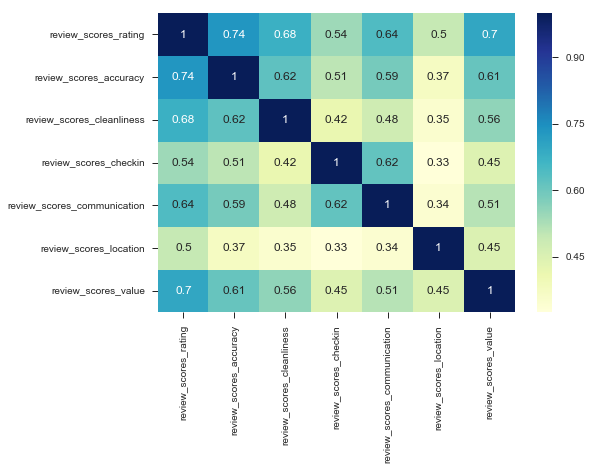

In [27]:
# Check correlation between various review scores. Will use 'review_scores_rating' as
# the overall review score for the list. Drop other review scores.
review = ld[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',\
           'review_scores_checkin', 'review_scores_communication','review_scores_location',\
            'review_scores_value']]
review.describe()
sns.set(style="ticks")
sns.heatmap(review.corr(), annot=True, cmap="YlGnBu");

# Clean data and determine feature importance

Training set has 3809 samples.
Testing set has 1633 samples.
0.640708658551
{'bootstrap': False, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


,feature,importance score
71,number_of_reviews,0.242711
66,cleaning_fee,0.061277
77,host_months,0.059282
59,host_response_time,0.047908
73,summary_length,0.038250


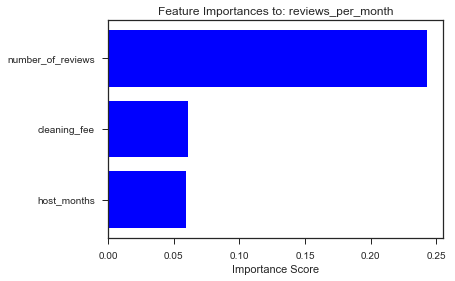

In [28]:
# set number of top features to list
top_n =3
#Determine feature importance for 'reviews_per_month'
response = 'reviews_per_month'
ld_cleaned = utility.get_cleaned_features(response,ld)
 
ld_X_y =pd.concat([ld[response],ld_cleaned], axis=1)
df_importance = utility.get_feature_importance(response,ld_X_y,top_n)
df_importance.head()

Training set has 3809 samples.
Testing set has 1633 samples.
0.215555129426
{'bootstrap': False, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


,feature,importance score
83,price,0.090257
61,calculated_host_listings_count,0.069216
71,number_of_reviews,0.056891
77,host_months,0.053081
53,host_is_superhost,0.052935


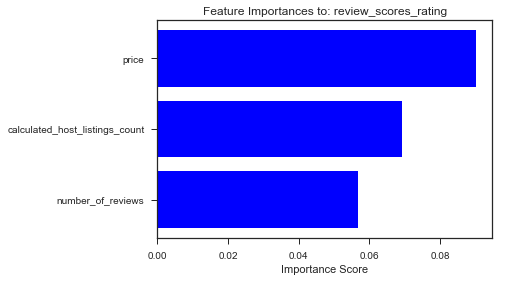

In [29]:
# Determine feature importance for 'review_scores_rating'
response = 'review_scores_rating'
ld_cleaned = utility.get_cleaned_features(response,ld)
ld_X_y =pd.concat([ld[response],ld_cleaned], axis=1)
df_importance = utility.get_feature_importance(response,ld_X_y,top_n)
df_importance.head()

Training set has 3809 samples.
Testing set has 1633 samples.
0.675847837853
{'bootstrap': False, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


,feature,importance score
81,reviews_per_month,0.281512
83,review_scores_rating,0.076720
76,host_months,0.066902
73,space_length,0.049445
66,cleaning_fee,0.043459


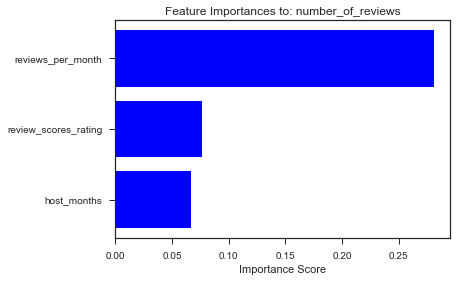

In [30]:
# Determine feature importance for 'reviews_per_month'
response = 'number_of_reviews'
ld_cleaned = utility.get_cleaned_features(response,ld)
 
ld_X_y =pd.concat([ld[response],ld_cleaned], axis=1)
df_importance = utility.get_feature_importance(response,ld_X_y,top_n)
df_importance.head()

Training set has 3809 samples.
Testing set has 1633 samples.
0.301266373323
{'bootstrap': False, 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


,feature,importance score
62,accommodates,0.127102
64,bedrooms,0.122508
66,cleaning_fee,0.114185
65,beds,0.085072
63,bathrooms,0.079420
67,security_deposit,0.046459
44,room_type_Entire home/apt,0.032244
82,reviews_per_month,0.030073
73,summary_length,0.028126
61,calculated_host_listings_count,0.023897


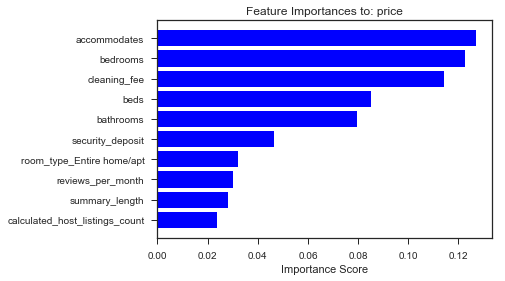

In [31]:
# Determine feature importance for 'price'
response = 'price'
ld_cleaned = utility.get_cleaned_features(response,ld)
 
ld_X_y =pd.concat([ld[response],ld_cleaned], axis=1)
df_importance = utility.get_feature_importance(response,ld_X_y,top_n=10)
df_importance.head(10)

# Determine amenities importance relative to target variable

In [32]:
#creating a dictionary of each amenities and the count value
list_amens = ld['amenities'].tolist()
list_amen_temp_a = []
for m in list_amens:
    list_amen_temp_a.append(m.split(','))

list_amen_temp_b = []
for m in list_amen_temp_a:
    for n in m:
        n=n.replace('"', '')
        n=n.replace('}', '')
        n=n.replace('{', '')
        n=n.replace(' ', '')
        list_amen_temp_b.append(n)

count = Counter(list_amen_temp_b)
count = dict(count)
#creating a dataframe with amenities and the number of houses providing the amenities
count_dict = {'amenities_available': list(count.keys()), 'num_amenities': list(count.values())}
#print(count_dict)
count_df = pd.DataFrame.from_dict(count_dict)
count_df[count_df['amenities_available'] == ''] = np.nan
count_df.sort_values(by = 'num_amenities', ascending = False, inplace = True)
count_df.dropna(inplace = True)
count_df.head(10)

,amenities_available,num_amenities
3,Wifi,5384.0
14,Essentials,5240.0
7,Heating,5187.0
11,Smokedetector,5085.0
17,Hangers,4806.0
15,Shampoo,4702.0
18,Hairdryer,4655.0
4,Kitchen,4548.0
19,Iron,4414.0
12,Carbonmonoxidedetector,4398.0


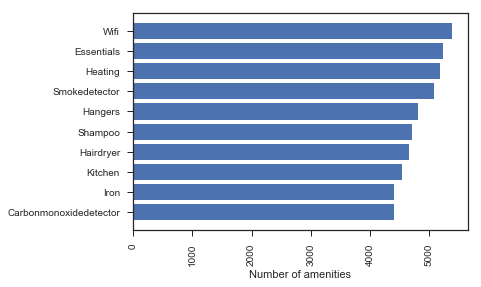

In [33]:
index = np.arange(10)
#plotting the number of amenities from the most to the least
fig, ax = plt.subplots(figsize=(6,4))
plt.barh(index,count_df.head(10)['num_amenities'])
plt.xticks(rotation = 'vertical')
plt.gca().invert_yaxis()
plt.xlabel("Number of amenities")
plt.yticks (index,count_df.head(10)['amenities_available'])
plt.show()

# Compare impact of top amenities on target variables

In [34]:
#add columns of top three amenities features
ld_cat_many = ld[['amenities']]
ld_cat_many['wifi_available'] = ld_cat_many['amenities'].apply(lambda x: 1 if 'Wifi' in x else 0)
ld_cat_many['heating_available'] = ld_cat_many['amenities'].apply(lambda x: 1 if 'Heating' in x else 0)
ld_cat_many['essentials_available'] = ld_cat_many['amenities'].apply(lambda x: 1 if 'Essentials' in x else 0)
ld_amenities= pd.concat([ld_cat_many,ld[response],ld_cleaned], axis=1).drop('amenities',axis=1)
ld_amenities.head()

,wifi_available,heating_available,essentials_available,price,neighbourhood_cleansed_Bayview,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,...,space_length,description_length,amenities_length,host_months,availability_30,availability_60,availability_90,availability_365,reviews_per_month,review_scores_rating
0,1,1,1,170.0,0,0,0,0,0,0,...,0.371,1.0,0.289750,0.960630,0.100000,0.083333,0.100000,0.334247,0.108730,0.9625
1,1,1,1,235.0,0,1,0,0,0,0,...,0.913,1.0,0.168684,0.905512,1.000000,1.000000,1.000000,1.000000,0.077778,0.9750
2,1,1,0,65.0,0,0,0,0,0,0,...,1.000,1.0,0.242938,0.874016,1.000000,1.000000,1.000000,1.000000,0.011905,0.8125
3,1,1,0,65.0,0,0,0,0,0,0,...,1.000,1.0,0.181598,0.874016,0.000000,0.383333,0.588889,0.898630,0.011111,0.8875
4,1,1,0,675.0,0,0,0,0,0,0,...,1.000,1.0,0.119451,0.874016,0.833333,0.800000,0.866667,0.213699,0.018254,0.9625


                heating      wifi  essentials
availability                                 
Not_Available  0.924706  0.857759    0.894369
Available      0.943766  0.943789    0.944742


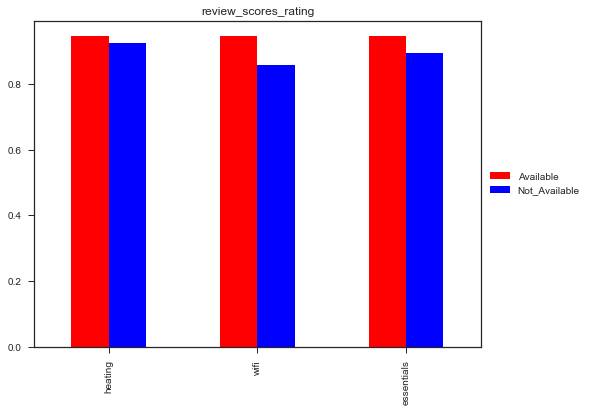

In [35]:
target = 'review_scores_rating'
utility.comparison_amenities(target,ld_amenities)

                heating      wifi  essentials
availability                                 
Not_Available  0.156729  0.079160    0.083895
Available      0.155047  0.155944    0.157872


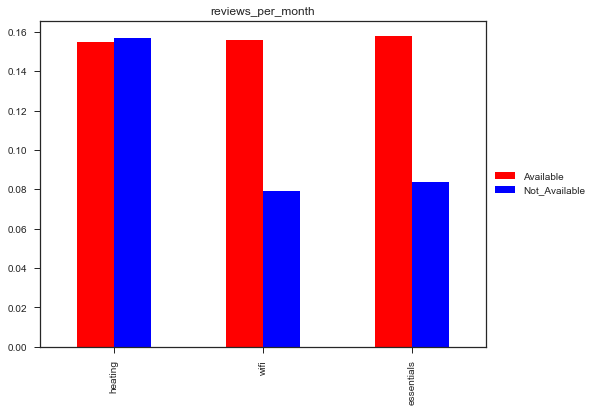

In [36]:
target = 'reviews_per_month'
utility.comparison_amenities(target,ld_amenities)